# Linear Model for csv_v1

## This markdown file deals with the creation of Logistic Regression combined_csv_v1

In [1]:
# importing the required libraries libraries
import warnings, requests, zipfile, io

warnings.simplefilter("ignore")
import pandas as pd
from scipy.io import arff

import os
import boto3
import sagemaker
from sagemaker.image_uris import retrieve
from sklearn.model_selection import train_test_split

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Function: initialize_s3_container

This function initializes an S3 bucket in a specified AWS region, creating a new storage container if it does not already exist. The function includes logic to handle both default and custom AWS regions.

In [2]:
import logging

# import boto3
from botocore.exceptions import ClientError

def initialize_s3_container(storage_name, locality=None):
    """
    Initialize an S3 storage bucket in a specified AWS region.
    If no region is specified, the bucket will default to 'us-east-1'.
    
    :param storage_name: Name of the bucket to create
    :param locality: AWS region for bucket creation, e.g., 'us-west-2'
    :return: True if bucket creation succeeds, otherwise False
    """

    try:
        if locality is None:
            s3_service = boto3.client("s3")
            s3_service.create_bucket(Bucket=storage_name)
        else:
            s3_service = boto3.client("s3", region_name=locality)
            config_location = {"LocationConstraint": locality}
            s3_service.create_bucket(
                Bucket=storage_name, CreateBucketConfiguration=config_location
            )

    except ClientError as error_log:
        logging.error(error_log)
        return False

    print(f"S3 Bucket: {storage_name} has been successfully created.")
    return True


# Function: verify_bucket_presence

This function checks whether an S3 bucket with a specified name exists in the AWS account. It’s helpful for ensuring that a required bucket is available before performing further operations, such as uploading data.

In [3]:
# Function to verify if the bucket exists
def verify_bucket_presence(storage_identifier):
    s3_resource = boto3.client("s3")
    try:
        s3_resource.head_bucket(Bucket=storage_identifier)
        print(f"Bucket '{storage_identifier}' is already available.")
        return True
    except ClientError as error_detected:
        # If a 404 error is encountered, the bucket does not exist
        if error_detected.response["Error"]["Code"] == "404":
            print(f"Bucket '{storage_identifier}' is not found.")
            return False
        else:
            # Raise any other error encountered
            raise


# S3 Bucket Setup and Validation

In this section, we set up the S3 bucket and check if it already exists. If the bucket does not exist, we create it to ensure that all necessary storage resources are available for our project.

In [8]:
# Set the S3 bucket name with valid characters
s3_container_name = "u3265713-uni-can-dsts-assn1"

# Fetch the S3 resource
s3_instance = boto3.Session().resource("s3")

# Check if the bucket exists
container_exists = verify_bucket_presence(s3_container_name)

# Create the bucket if it doesn't exist
if not container_exists:
    initialize_s3_container(s3_container_name)



Bucket 'u3265713-uni-can-dsts-assn1' is not found.
S3 Bucket: u3265713-uni-can-dsts-assn1 has been successfully created.


# Setting S3 Path Prefix and Uploading CSV Data to S3

In this section, we define a prefix for the S3 path and create a function to upload a DataFrame as a CSV file to an S3 bucket. This setup is essential for organizing and storing data in a structured manner within AWS S3.

In [9]:
# Setting the prefix for the S3 path
s3_prefix = "oncloud"

# Function to upload CSV data to AWS S3
def upload_csv_to_s3(file_name, subfolder, data_frame):
    csv_memory_buffer = io.StringIO()
    data_frame.to_csv(csv_memory_buffer, header=False, index=False)
    print(s3_instance.Bucket(s3_container_name))
    s3_instance.Bucket(s3_container_name).Object(os.path.join(s3_prefix, subfolder, file_name)).put(
        Body=csv_memory_buffer.getvalue()
    )


# Loading the Dataset

In [11]:
# Load the data
dataset_v1 = pd.read_csv("./combined_csv_v1.csv")

print(dataset_v1.head())
print(dataset_v1.shape)


   target  Distance  Quarter_2  Quarter_3  Quarter_4  Month_2  Month_3  \
0     0.0     689.0      False      False      False    False    False   
1     0.0     731.0      False      False      False    False    False   
2     0.0    1199.0      False      False      False    False    False   
3     0.0    1587.0      False      False      False    False    False   
4     0.0    1587.0      False      False      False    False    False   

   Month_4  Month_5  Month_6  ...  Dest_DEN  Dest_DFW  Dest_IAH  Dest_LAX  \
0    False    False    False  ...     False     False      True     False   
1    False    False    False  ...     False     False     False     False   
2    False    False    False  ...      True     False     False     False   
3    False    False    False  ...     False     False     False     False   
4    False    False    False  ...     False     False     False     False   

   Dest_ORD  Dest_PHX  Dest_SFO  DepHourofDay_7-12  DepHourofDay_13-18  \
0     False     Fa

# Creating a Copy of the Dataset

In [13]:
# Copying the data 
df = dataset_v1.copy()

# Data Transformation: Converting Boolean Values

In [14]:
# Replacing True/False with 1/0 directly in df
df = df.replace({True: 1, False: 0})
df.head(5)


,target,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,DepHourofDay_7-12,DepHourofDay_13-18,DepHourofDay_19-23
0,0.0,689.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0.0,731.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.0,1199.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0.0,1587.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0.0,1587.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# Splitting the dataset

In [15]:
# Split the data into training and a combined testing/validation set (70% train, 30% test/validate)
training_data, testing_validation_data = train_test_split(
    df, test_size=0.3, random_state=42, stratify=df["target"]
)

# Further split the testing_validation_data set into separate testing and validation sets (15% each of the original data)
testing_data, validation_data = train_test_split(
    testing_validation_data,
    test_size=0.5,
    random_state=42,
    stratify=testing_validation_data["target"],
)


In [16]:
# Printing the shapes of each set 
print(training_data.shape)
print(testing_data.shape)
print(validation_data.shape)


(1144913, 75)
(245338, 75)
(245339, 75)


# Defining File Names for Data Subsets

In [17]:
# Set the names of the CSV files for each data subset
# These file names will be used to save the training, testing, and validation datasets 
# as CSV files, allowing for easy upload to S3 and subsequent use in modeling.
training_file_name = "data_v1_train.csv"      # Filename for the training dataset
testing_file_name = "data_v1_test.csv"        # Filename for the testing dataset
validation_file_name = "data_v1_validate.csv" # Filename for the validation dataset


# Preparing Data for SageMaker Training

The transform_data_for_sagemaker function converts a DataFrame into a SageMaker-compatible format. It separates feature vectors and target labels, storing them in an in-memory binary buffer. This format is optimized for SageMaker’s training processes.

In [19]:
import io
import numpy as np
import sagemaker.amazon.common as smac

# Function to prepare data for SageMaker training
# This function converts a dataframe into a format suitable for SageMaker training,
# separating features (input data) and labels (target values) and storing them in 
# an in-memory binary buffer that SageMaker can efficiently use.
def transform_data_for_sagemaker(input_df):
    # Extract feature vectors by dropping the target column and converting to float32
    feature_vectors = input_df.drop(columns=["target"]).values.astype("float32")
    # Extract target labels from the target column and convert to float32
    target_labels = input_df["target"].values.astype("float32")
    # Initialize an in-memory binary stream buffer to hold the transformed data
    memory_buffer = io.BytesIO()
    # Use SageMaker's utility function to write data in dense tensor format into the buffer
    smac.write_numpy_to_dense_tensor(memory_buffer, feature_vectors, target_labels)
    # Reset buffer position to the start to allow SageMaker to read from the beginning
    memory_buffer.seek(0)
    # Return the in-memory buffer ready for SageMaker ingestion
    return memory_buffer


In [20]:
# Function to upload a data buffer to S3
# This function takes an in-memory buffer, S3 bucket, prefix, and data type (e.g., train, test),
# and uploads the data in 'recordIO' format to a specified location in the S3 bucket.

def upload_buffer_to_s3(data_buffer, s3_bucket, s3_prefix, data_type):
    # Set a fixed S3 key (filename) for the data
    s3_key_name = "recordio-pb-data"
    
    # Perform the upload to the specified S3 bucket and path
    boto3.resource("s3").Bucket(s3_bucket).Object(
        os.path.join(s3_prefix, data_type, s3_key_name)
    ).upload_fileobj(data_buffer)
    
    # Construct and print the S3 path where the data has been uploaded
    s3_data_path = "s3://{}/{}/{}/{}".format(s3_bucket, s3_prefix, data_type, s3_key_name)
    print("Uploaded {} data to location: {}".format(data_type, s3_data_path))
    
    # Return the S3 path for reference
    return s3_data_path

# Uploading Data Buffer to S3

In [21]:
# Prepare training data buffer for SageMaker
# Converts the training dataset into a format suitable for SageMaker and stores it in an in-memory buffer
training_data_buffer = transform_data_for_sagemaker(training_data)
# Upload the training data buffer to S3
# This uploads the training buffer to the specified S3 bucket under the prefix path for "train" data
s3_training_data_path = upload_buffer_to_s3(training_data_buffer, s3_container_name, s3_prefix, "train")
# Prepare validation data buffer for SageMaker
# Converts the validation dataset into a SageMaker-compatible format and stores it in an in-memory buffer
validation_data_buffer = transform_data_for_sagemaker(validation_data)
# Upload the validation data buffer to S3
# This uploads the validation buffer to the specified S3 bucket under the prefix path for "validate" data
s3_validation_data_path = upload_buffer_to_s3(validation_data_buffer, s3_container_name, s3_prefix, "validate")


Uploaded train data to location: s3://u3265713-uni-can-dsts-assn1/oncloud/train/recordio-pb-data
Uploaded validate data to location: s3://u3265713-uni-can-dsts-assn1/oncloud/validate/recordio-pb-data


# Setting the S3 Output Location for Training Artifacts

In [22]:
# Define the S3 output location for training artifacts
# This path specifies where SageMaker should store the output artifacts after training is complete.
# The output location is set under the specified S3 bucket and prefix, organized in an "output" folder.
output_artifact_location = "s3://{}/{}/output".format(s3_container_name, s3_prefix)
# Print the S3 path where training artifacts will be uploaded
print("Training artifacts will be uploaded to: {}".format(output_artifact_location))


Training artifacts will be uploaded to: s3://u3265713-uni-can-dsts-assn1/oncloud/output


# Retrieving the SageMaker Container Image URI

In [23]:
from sagemaker.image_uris import retrieve
# Retrieve the container image URI for the SageMaker algorithm
# This retrieves the URI for the specified algorithm container (linear-learner) in the given AWS region.
# The container image is needed to launch the training job on SageMaker using the specified algorithm.
model_container_uri = retrieve("linear-learner", "us-east-1")


# Setting Up and Running the SageMaker Training Job

In [25]:
# Create a SageMaker session
# This session is initialized with the specified region (us-east-1) to match the region of the S3 bucket.
# It will manage the communication with AWS services for the training job.
sagemaker_session = sagemaker.Session(boto3.session.Session(region_name="us-east-1"))
# Retrieve the IAM role for SageMaker
# The role grants SageMaker permissions to access AWS resources such as S3.
execution_role = sagemaker.get_execution_role()
# Set up the SageMaker Estimator for training a linear model
# This estimator is configured with the model container URI, IAM role, instance count, instance type,
# output path for training artifacts, and the SageMaker session.
linear_estimator = sagemaker.estimator.Estimator(
    model_container_uri,            # Container URI for the chosen algorithm (linear-learner)
    execution_role,                 # IAM role for SageMaker permissions
    train_instance_count=1,         # Number of instances for training (1 in this case)
    train_instance_type="ml.c5.4xlarge",  # Instance type for training
    output_path=output_artifact_location, # S3 location for output artifacts
    sagemaker_session=sagemaker_session  # Session for AWS resource management
)
# Set hyperparameters for the linear model
# Here, we specify the feature dimension and the type of predictor (binary classifier).
linear_estimator.set_hyperparameters(feature_dim=74, predictor_type="binary_classifier")
# Start the training job on SageMaker
# The training data and validation data are passed as input channels to the estimator.
# Setting logs=False suppresses detailed logging during training.
linear_estimator.fit({"train": s3_training_data_path, "validation": s3_validation_data_path}, logs=False)


See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.



2024-11-03 06:01:39 Starting - Starting the training job..
2024-11-03 06:01:53 Starting - Preparing the instances for training.....
2024-11-03 06:02:25 Downloading - Downloading input data....
2024-11-03 06:02:50 Downloading - Downloading the training image........
2024-11-03 06:03:35 Training - Training image download completed. Training in progress.........................................................................
2024-11-03 06:09:42 Uploading - Uploading generated training model
2024-11-03 06:09:50 Completed - Training job completed


# Preparing and Uploading Data for Batch Prediction

In [26]:
# Prepare the input data for batch prediction
# This selects all columns except the target from the test data for predictions.
# The data will be saved in a CSV format for batch processing on SageMaker.
batch_input_data_df = testing_data.iloc[:, 1:]         # Exclude target column for batch prediction
batch_input_file_name = 'batch-input-linear.csv'       # Name for the batch input CSV file

# Upload the batch input data CSV to S3
# This function uploads the batch prediction input file to a specific S3 location.
upload_csv_to_s3(batch_input_file_name, 'batch-input-folder', batch_input_data_df)

# Define S3 paths for batch input and output
# The batch_output_path specifies where SageMaker should store the prediction results.
# The batch_input_path points to the location of the uploaded CSV file in S3.
batch_output_path = "s3://{}/{}/batch-output-linear/".format(s3_container_name, s3_prefix)
batch_input_path = "s3://{}/{}/batch-input-folder/{}".format(s3_container_name, s3_prefix, batch_input_file_name)


s3.Bucket(name='u3265713-uni-can-dsts-assn1')


# Setting Up and Running the Batch Transform Job

In [27]:
# Create the transformer object for the Linear Learner model
# The transformer handles batch predictions by using the trained model and specified S3 locations for input and output.
# We configure the instance count and type for the transform job, as well as data handling strategies.
linear_model_transformer = linear_estimator.transformer(
    instance_count=1,                       # Number of instances to use for batch transform
    instance_type='ml.c5.4xlarge',          # Instance type for the transform job
    strategy='MultiRecord',                 # Strategy for combining multiple records into a single batch request
    assemble_with='Line',                   # Assembling records by line, suitable for CSV format
    output_path=batch_output_path           # S3 path to store the batch prediction results
)

# Start the batch transform job
# This initiates the transform job using the transformer, specifying the input data and content type.
linear_model_transformer.transform(
    data=batch_input_path,                  # S3 path of input data for batch predictions
    data_type='S3Prefix',                   # Type of data in S3 (prefix for files in this case)
    content_type='text/csv',                # Content type of input data
    split_type='Line',                      # Split records by line (each line represents one data instance)
    logs=False                              # Suppress logging during the batch transform job
)

# Wait for the batch transform job to complete
linear_model_transformer.wait()


.......................................................................................!
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/03/2024 06:20:33 INFO 140106871093056] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/03/2024 06:20:33 INFO 140106871093056] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/op

# Retrieving and Reading Batch Prediction Results from S3

In [28]:
# Fetch and read the batch prediction output from S3
# This code retrieves the batch transform output file from S3 and reads it into a DataFrame for further analysis.
s3_client = boto3.client('s3')
# Define the S3 key for the batch output file
# This path points to the output folder and file created by the batch transform job.
batch_output_key = "{}/batch-output-linear/{}".format(s3_prefix, 'batch-input-linear.csv.out')
# Fetch the output object from S3
# Retrieves the batch prediction results from the specified S3 bucket and key.
output_object = s3_client.get_object(Bucket=s3_container_name, Key=batch_output_key)
# Read the prediction results into a DataFrame
# Loads the output data from the batch transform job into a DataFrame.
# The DataFrame is assigned column name 'class' to represent the predicted classes.
predicted_target_df = pd.read_csv(io.BytesIO(output_object['Body'].read()), header=None, names=['class'])
# Print or further process the predictions
# Display the first few rows of predictions to verify results or for further analysis.
predicted_target_df.head(5)


,class
"{""predicted_label"":0",score:0.20226565003395}
"{""predicted_label"":0",score:0.20329600572586}
"{""predicted_label"":0",score:0.188853055238723}
"{""predicted_label"":0",score:0.200587853789329}
"{""predicted_label"":0",score:0.203493922948837}


# Extracting and Processing Prediction Results

In [29]:
# Extract the prediction indices from the DataFrame
# This extracts the indices of each prediction result for further processing.
predicted_indices = predicted_target_df.index

# Example of accessing the last character of the first prediction index
# Retrieves the last character from the first index, which might represent a label or identifier.
predicted_indices[0][-1]

# Extract the middle portion of the first prediction result
# Slices the first prediction string to exclude specific characters (used here as an example).
predicted_target_df.iloc[0, 0][6:-1]

# Define a list of prediction labels based on the indices
# Extracts the last character of each index, assuming it represents the prediction label.
predicted_labels = [str(pred_index)[-1] for pred_index in predicted_indices]

# Define a list of prediction scores based on the DataFrame rows
# Extracts the prediction score for each row, excluding specific characters.
predicted_scores = [str(row[0])[6:-1] for row in predicted_target_df.itertuples(index=False)]

# Convert prediction scores and labels to numeric types
# Ensures the extracted scores and labels are in numeric form for further analysis.
predicted_scores = pd.to_numeric(predicted_scores)
predicted_labels = pd.to_numeric(predicted_labels)


# Plotting the Confusion Matrix

In [30]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Function to plot a confusion matrix
# This function generates a heatmap to visualize the confusion matrix,
# which helps assess the accuracy of classification by comparing actual and predicted labels.
def display_confusion_matrix(actual_labels, predicted_labels):
    # Generate the confusion matrix
    # The matrix compares actual labels with predicted labels to show true positives, false positives, etc.
    confusion_mat = confusion_matrix(actual_labels, predicted_labels)
    # Create a heatmap for the confusion matrix
    # This provides a visual representation of the matrix for easy interpretation.
    sns.heatmap(
        confusion_mat,
        annot=True,               # Display numerical values within each cell
        fmt="d",                  # Format as integer values
        cmap="Blues",             # Color scheme for the heatmap
        xticklabels=["On-Time", "Delayed"],  # Labels for the x-axis (predicted outcomes)
        yticklabels=["On-Time", "Delayed"],  # Labels for the y-axis (actual outcomes)
    )
    # Label the plot axes and title
    plt.xlabel("Predicted Labels")  # Label for the x-axis
    plt.ylabel("Actual Labels")     # Label for the y-axis
    plt.title("Confusion Matrix")   # Title of the plot
    plt.show()                      # Display the plot

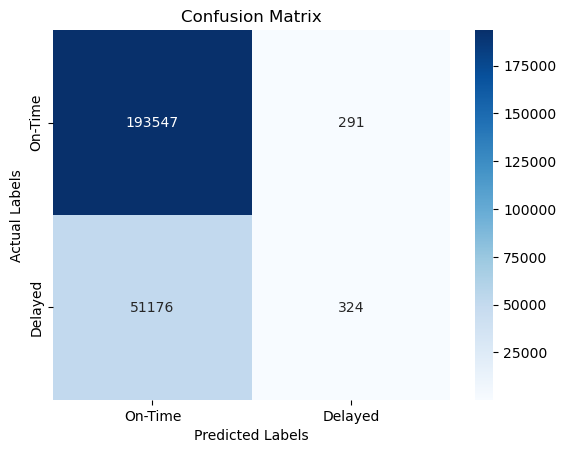

In [31]:
# Display confusion matrix for the test data
# This compares the actual test labels with the predicted labels and visualizes the classification performance.
# `test.iloc[:, 0]` extracts the actual labels from the test dataset.
display_confusion_matrix(
    actual_labels=testing_data.iloc[:, 0],  # Actual labels from the first column of test data
    predicted_labels=predicted_labels       # Predicted labels obtained from the model
)


# Generating the Classification Report

In [32]:
from sklearn.metrics import classification_report

# Generate and display the classification report for the test data
# This report provides detailed metrics such as precision, recall, and F1-score
# for each class, helping assess the performance of the model.
print("Classification Report on Test Data")
print(classification_report(
    testing_data.iloc[:, 0],    # Actual labels from the first column of test data
    predicted_labels             # Predicted labels generated by the model
))


Classification Report on Test Data
              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88    193838
         1.0       0.53      0.01      0.01     51500

    accuracy                           0.79    245338
   macro avg       0.66      0.50      0.45    245338
weighted avg       0.74      0.79      0.70    245338



### Accuracy

csv_1 Model: 79%
csv_2 Model: 79%

**Analysis: Both models achieved the same accuracy, indicating similar overall correctness. However, accuracy alone may not provide a complete view, given the class imbalance in the data.**

### Precision and Recall by Class

Class 0 (On-Time):
Precision: csv_1 - 0.79, csv_2 - 0.80
Recall: csv_1 - 1.00, csv_2 - 0.99

**Analysis: Both models perform well on the "On-Time" class, with high precision and recall values, showing reliable prediction for the majority class.**

Class 1 (Delayed):
Precision: csv_1 - 0.53, csv_2 - 0.56
Recall: csv_1 - 0.01, csv_2 - 0.07

**Analysis: The csv_2 model demonstrates better performance on the "Delayed" class, with both higher precision and significantly better recall compared to csv_1. This indicates that csv_2 is better at identifying delayed instances, although both models struggle with this class.**

### F1-Score

Macro Average F1-Score:
csv_1: 0.45
csv_2: 0.50

Weighted Average F1-Score:
csv_1: 0.70
csv_2: 0.72

**Analysis: The csv_2 model has slightly higher macro and weighted average F1-scores, indicating a better balance in performance across both classes.**


### Conclusion: 

The model trained on csv_2 is preferable for business needs, as it demonstrates better performance in predicting delayed instances (Class 1). Although both models have similar overall accuracy, the csv_2 model provides improved recall and F1-scores for the delayed class, aligning more closely with the goal of accurately identifying delays.